### Cylindrical Epithelium 

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib qt

import graph_tool.all as gt
import pandas as pd

from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
### Typical number of cells around the cylinder
n_circum = 8
### Typical number of cells along z
n_length = 7
### Distance between 2 cells
l_0 = 1. 
### Cells heights
h_0 = 1.

In [3]:
rho_c = n_circum * l_0 / (2 * np.pi)
rho_lumen = rho_c - h_0

delta_theta = 2 * np.pi / n_circum
delta_z = delta_theta * rho_c * np.sqrt(3)/2.

zt_grid = np.mgrid[:n_length, :n_circum]
thetas = zt_grid[1].astype('float')
thetas[::2, ...] += 0.5
thetas *= delta_theta
thetas = thetas.flatten()
zeds = zt_grid[0].astype('float')
zeds *= delta_z
zeds -= zeds.max() / 2
zeds = zeds.flatten()

cell_pos = np.zeros((n_circum * n_length, 3))

cell_pos[:, 0] = np.cos(thetas) * rho_c
cell_pos[:, 1] = np.sin(thetas) * rho_c
cell_pos[:, 2] = zeds

In [4]:
cells_graph, pos_vp = gt.geometric_graph(cell_pos, l_0*1.1)

In [5]:
rhos = np.linalg.norm(cell_pos[:, :2], axis=1)
z_angle = np.pi/24
d_theta = np.pi/12

pseudo_x = cell_pos[:, 2] * np.cos(z_angle) - rhos * np.sin(thetas + d_theta) * np.sin(z_angle)
pseudo_y = rhos * np.cos(thetas + d_theta)

pseudo_pos = gt.graph_draw(cells_graph, output='generated_cells.png')

![the generated cells](generated_cells.png)

In [6]:
cell_pos = pd.DataFrame(cell_pos, columns=['x', 'y', 'z'])
cell_pos.index.name = 'cell'


In [7]:
thetas = np.arctan2(cell_pos['y'], cell_pos['x'])
rhos = np.hypot(cell_pos['y'], cell_pos['x'])
cell_pos['theta'] = thetas
cell_pos['sigma'] = thetas * rhos
cell_pos['rho'] = rhos
cell_pos['sigma_r'] = ((thetas) % (2*np.pi)) * rhos

voronoi = Voronoi(cell_pos[['z', 'sigma']].values)
voronoi_r = Voronoi(cell_pos[['z', 'sigma_r']].values)

#plt.plot(pos.z, pos.sigmas, 'bo')
fig, (ax, ax_r) = plt.subplots(1, 2)

voronoi_plot_2d(voronoi, ax=ax)
voronoi_plot_2d(voronoi_r, ax=ax_r)

for c in cell_pos.index:
    ax.text(cell_pos.loc[c, 'z'], cell_pos.loc[c, 'sigma'], str(c))
    ax_r.text(cell_pos.loc[c, 'z'], cell_pos.loc[c, 'sigma_r'], str(c))

    
ax.set_aspect('equal')
ax_r.set_aspect('equal')


In [8]:
ridges = [(k, v, 0) for (k, v) in voronoi.ridge_dict.items()]
for (k, v) in voronoi_r.ridge_dict.items():
    if (not k in voronoi.ridge_dict) and (not (k[1], k[0]) in voronoi.ridge_dict):
        ridges.append((k, v, 1))

print(len(voronoi_r.ridge_dict), len(ridges))

144 162


In [13]:
graph = gt.Graph(directed=True)

zeds = graph.new_vertex_property('double')
thetas = graph.new_vertex_property('double')
is_cell_vert = graph.new_vertex_property('bool')
is_junction_edge = graph.new_edge_property('bool')


def add_ctoj(c, j, graph, is_junction_edge):
    if graph.edge(c, j) is None:
        c2j = graph.add_edge(c, j)
        is_junction_edge[c2j] = 0
        return c2j
        
def add_je(j0, j1, graph, is_junction_edge):
    if graph.edge(j0, j1) is None:
        je = graph.add_edge(j0, j1)
        is_junction_edge[je] = 1
        return je


cell_idx_dict = {}
jv_idx_dict = {}


def add_cell(graph, vor, c, cell_idx_dict, zeds, thetas, is_cell_vert):
    if not c in cell_idx_dict:
        cell = graph.add_vertex()
        zeds[cell] = vor.points[c, 0]
        thetas[cell] = (vor.points[c, 1]/rho_c) % (2*np.pi) - np.pi
        is_cell_vert[cell] = 1
        cell_idx_dict[c] = cell
        return cell
    else:
        return cell_idx_dict[c]

def add_jv(graph, vor, j, jv_idx_dict, zeds, thetas, is_cell_vert):
    if not (j, vor) in jv_idx_dict:
        jv = graph.add_vertex()
        zeds[jv] = vor.vertices[j, 0]
        thetas[jv] = (vor.vertices[j, 1]/rho_c) % (2*np.pi) - np.pi
        is_cell_vert[jv] = 0
        jv_idx_dict[(j, vor)] = jv
        return jv
    else:
        return jv_idx_dict[(j, vor)]
    
    
for (c0, c1), (j0, j1), i in ridges:
    
    vor = voronoi if i == 0 else voronoi_r



    cell0 = add_cell(graph, vor, c0, cell_idx_dict, 
                     zeds, thetas, is_cell_vert)
    cell1 = add_cell(graph, vor, c1, cell_idx_dict, 
                     zeds, thetas, is_cell_vert)
    if j0 != -1:
        jv0 = add_jv(graph, vor, j0, jv_idx_dict, 
                     zeds, thetas, is_cell_vert)
        c2j_00 = add_ctoj(cell0, jv0, graph, is_junction_edge)
        c2j_10 = add_ctoj(cell1, jv0, graph, is_junction_edge)
    if j1 != -1:
        
        jv1 = add_jv(graph, vor, j1, jv_idx_dict, 
                 zeds, thetas, is_cell_vert)
        c2j_01 = add_ctoj(cell0, jv1, graph, is_junction_edge)
        c2j_11 = add_ctoj(cell1, jv1, graph, is_junction_edge)
    if not -1 in (j0, j1):
        je = add_je(jv0, jv1, graph, is_junction_edge)
    


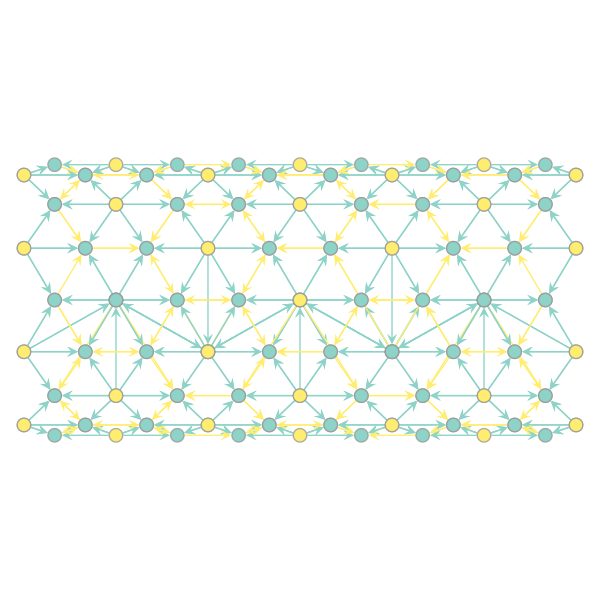

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff83bb5bfd0, at 0x7ff83bb58160>

In [15]:
ixs = zeds.copy()
wys = zeds.copy()
ixs.a = rho_c * np.cos(thetas.a)
wys.a = rho_c * np.sin(thetas.a)
ps_x = ixs.copy()
ps_y = ixs.copy()
z_angle = np.pi

d_theta = -np.pi/2

ps_x.a = zeds.a * np.cos(z_angle) - rho_c * np.sin(thetas.a + d_theta) * np.sin(z_angle)
ps_y.a = rho_c * np.cos(thetas.a + d_theta)
xy = gt.group_vector_property([ps_x, ps_y])


gt.graph_draw(graph, xy, inline=True, 
              vertex_fill_color=is_cell_vert, 
              edge_color=is_junction_edge, vorder=zeds)


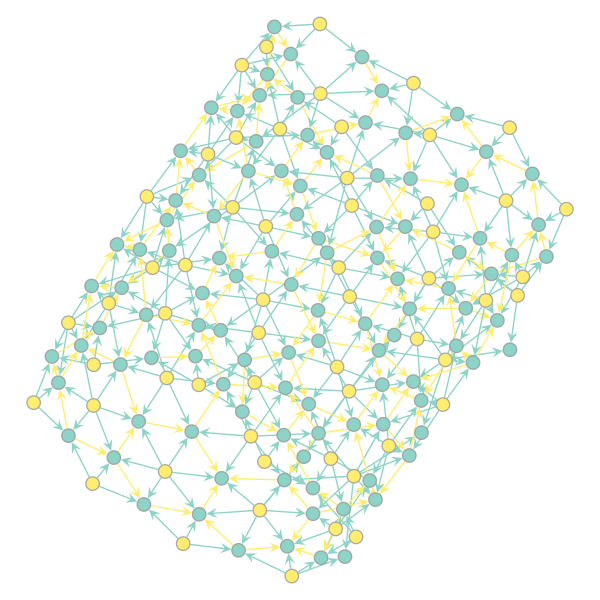

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff83bb5bfd0, at 0x7ff83bcfc3c8>

In [18]:
gt.graph_draw(graph,  inline=True, 
              vertex_fill_color=is_cell_vert, 
              edge_color=is_junction_edge)


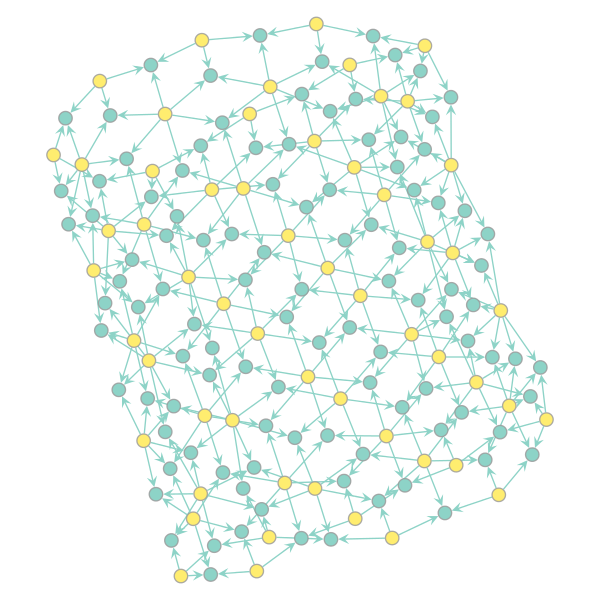

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff83bb5bfd0, at 0x7ff83bce50f0>

In [19]:
seam_motif = gt.Graph(directed=True)

verts = seam_motif.add_vertex(8)
verts = list(verts)

graph.set_edge_filter(is_junction_edge, inverted=True)

gt.graph_draw(graph,  inline=True, 
              vertex_fill_color=is_cell_vert, 
              edge_color=is_junction_edge)

In [96]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(voronoi_3d.vertices[:, 0], voronoi_3d.vertices[:, 1], voronoi_3d.vertices[:, 2], c='k')
ax.scatter(voronoi_3d.points[:, 0], voronoi_3d.points[:, 1], voronoi_3d.points[:, 2], c='r')

for simplex in voronoi_3d.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        ax.plot(voronoi_3d.vertices[simplex, 0], 
                voronoi_3d.vertices[simplex, 1],
                voronoi_3d.vertices[simplex, 2], 'k-')
